# Customer Retention

The guided tutorial that accompanies this code is located at https://difit.datakind.org/. 

The tutorial content begins at the "Tutorial" heading. The first several cells are prep work to use the tutorial including setting up the environment and creating the synthetic datasets for the tutorial. Thus, these are necessary to run if you would like to use the tutorial, however, they are not included in the tutorial text. 

# Prep Work

## Import Libraries

In [1]:
import pyod
from pyod.models.ecod import ECOD
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## Create Synthetic Datasets

In [2]:
# Set seed for reproducibility
np.random.seed(37)

num_samples = 2000

cluster_centers = {
    ('Bogota') : [700, 55000000, 40, 1.5, 2500000, 10000000],
    ('Medellin') : [625, 47500000, 35, 1, 2700000, 5000000],
    ('Cartagena') : [550, 40000000, 30, .5, 2000000, 2000000]
}


user_id = np.arange(1, num_samples + 1)

churn = np.random.choice([0, 1], size=num_samples, p=[0.8, 0.2])

gender = [np.random.choice(['male' ,'female'], p=[0.3, 0.7]) if c == 1 else np.random.choice(['male' ,'female'], p=[0.7, 0.3]) for c in churn]

location = [np.random.choice(['Bogota', 'Medellin', 'Cartagena'],p=[0.7,0.2,0.1]) if c==1 else np.random.choice(['Bogota', 'Medellin', 'Cartagena'],p=[0.1,0.4,0.5]) for c in churn]

loan_open = [np.random.choice([0, 1], p=[0.45, 0.55]) if c == 1 else np.random.choice([0, 1], p=[0.25, 0.75]) for c in churn]

payments_made = [np.random.choice([0, 1, 2, 3 ], p=[0.2,.3,.2,.3]) if c == 1 else 0 for c in loan_open]

on_time_payments = [max(0, np.random.binomial(paid, 0.8)) for paid in payments_made]

late_payments = [paid - on_time for paid, on_time in zip(payments_made, on_time_payments)]

account_delq = [late > 0 and np.random.rand() < 0.1 for late in late_payments]

credit_scores = []
incomes = []
ages = []
number_past_loans = []
amount_borrowed_in_past = []
savings = []
number_past_defaults = []
for i in range(num_samples):
    loc = location[i]
    center = cluster_centers[(loc)]
    churn_val = churn[i]
    credit_score = np.random.normal(loc=center[0], scale=150)
    income = np.random.normal(loc=center[1], scale=5000000)
    age = np.random.normal(loc=center[2], scale=10)
    number_past_loan = max(np.random.lognormal(mean=center[3], sigma=.1),0)
    if number_past_loan > 0:
        if churn_val == 1:
            number_past_default = number_past_loan - np.random.randint(0, number_past_loan)
        else:
            number_past_default = number_past_loan - np.random.randint(1, number_past_loan+1)
    else:
        number_past_default = 0
    amount_borrowed = np.random.normal(loc=center[4], scale=500000)
    saving = np.random.normal(loc=center[5], scale=500000)   
    credit_scores.append(credit_score)
    incomes.append(income)
    ages.append(age)
    number_past_loans.append(number_past_loan)
    number_past_defaults.append(number_past_default)
    amount_borrowed_in_past.append(amount_borrowed)
    savings.append(saving)

credit_scores = np.array(credit_scores)
incomes = np.array(incomes)
ages = np.array(ages)
number_past_loans = np.array(number_past_loans)
amount_borrowed_in_past = np.array(amount_borrowed_in_past)
savings = np.array(savings)
number_past_defaults = np.array(number_past_defaults)

ages = ages.astype(int)
credit_scores = credit_scores.astype(int)
number_past_loans = number_past_loans.astype(int)
number_past_defaults = number_past_defaults.astype(int)

ages = np.clip(ages, 18, 85)
credit_scores = np.clip(credit_scores, 350, 850)

loan_orig_amt = [max(0, np.random.normal(loc=(incomes[i]/48), scale=(incomes[i]/4800))) for i in range(num_samples)]

if loan_open[i] == 1:
    months_since_last_loan_opened = 0
else:
    months_since_last_loan_opened = [np.random.randint(2, 6) if c == 1 else np.random.randint(0, 5) for c in churn]
months_since_last_loan_opened = np.array(months_since_last_loan_opened).astype(int)

payment_date = [np.random.randint(1, 29) for _ in range(num_samples)]

df = pd.DataFrame({
    'user_id': user_id,
    'gender': gender,
    'location': location,
    'credit_score': credit_scores,
    'income': incomes,
    'age': ages,
    'loan_open': loan_open,
    'installments_paid': payments_made,
    'number_past_loans': number_past_loans,
    'number_past_default': number_past_defaults,
    'amount_borrowed_in_past': amount_borrowed_in_past,
    'savings': savings,
    'months_since_last_loan_opened': months_since_last_loan_opened,
    'payment_date': payment_date,
    'on_time_payments': on_time_payments,
    'late_payments': late_payments,
    'account_delq': account_delq,
    'loan_orig_amt': loan_orig_amt,
    'churn': churn
})


In [3]:
churn_df = df.copy()
np.random.seed(37)
churn_df = churn_df[['user_id', 'churn', 'months_since_last_loan_opened']]
churn_df['months_since_last_loan_opened_current'] = [np.random.randint(6,12) if c == 1 else np.random.randint(0, 5) for c in churn]
churn_df = churn_df[['user_id', 'months_since_last_loan_opened_current']]
df = df.drop(columns=['churn'])

In [4]:
churn_df.head(n=10)

,user_id,months_since_last_loan_opened_current
0,1,9
1,2,4
2,3,3
3,4,4
4,5,2
5,6,3
6,7,3
7,8,2
8,9,0
9,10,0


# Tutorial

## Exploratory

In [5]:
df.head(n =10)

,user_id,gender,location,credit_score,income,age,loan_open,installments_paid,number_past_loans,number_past_default,amount_borrowed_in_past,savings,months_since_last_loan_opened,payment_date,on_time_payments,late_payments,account_delq,loan_orig_amt
0,1,female,Bogota,850,5.273485e+07,28,1,3,4,4,3.222667e+06,1.039848e+07,0,11,2,1,False,1.111719e+06
1,2,male,Bogota,683,5.906139e+07,36,1,2,3,1,2.668377e+06,1.044348e+07,0,27,2,0,False,1.228536e+06
2,3,female,Medellin,707,4.912086e+07,18,1,2,2,1,1.925105e+06,4.995386e+06,0,23,2,0,False,1.011201e+06
3,4,male,Medellin,734,5.416028e+07,21,1,1,2,1,2.882691e+06,4.219940e+06,0,11,1,0,False,1.122043e+06
4,5,male,Cartagena,733,4.138744e+07,59,1,1,1,0,1.659045e+06,1.515156e+06,0,12,1,0,False,8.569238e+05
5,6,female,Cartagena,350,4.468375e+07,24,1,1,1,0,9.541824e+05,2.455149e+06,0,18,0,1,False,9.150738e+05
6,7,male,Medellin,394,4.726781e+07,30,1,1,3,0,2.907275e+06,5.052268e+06,0,12,0,1,False,9.902872e+05
7,8,female,Bogota,679,5.285692e+07,35,1,3,4,3,3.153196e+06,1.021021e+07,0,23,1,2,False,1.108350e+06
8,9,male,Medellin,361,4.982105e+07,33,0,0,2,0,3.041399e+06,5.527570e+06,0,23,0,0,False,1.035419e+06
9,10,male,Cartagena,764,3.799284e+07,27,1,2,1,0,2.318510e+06,1.493056e+06,0,28,2,0,False,7.864309e+05


In [6]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()

,user_id,credit_score,income,age,loan_open,installments_paid,number_past_loans,number_past_default,amount_borrowed_in_past,savings,months_since_last_loan_opened,payment_date,on_time_payments,late_payments,loan_orig_amt
count,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00
mean,1000.50,606.27,45922736.96,33.75,0.73,1.16,2.08,0.74,2362458.80,4808823.67,0.00,14.72,0.93,0.23,957250.20
std,577.49,143.73,7720597.96,10.11,0.45,1.19,1.17,1.06,595307.12,3061389.37,0.00,7.95,1.05,0.48,161193.82
min,1.00,350.00,24004760.73,18.00,0.00,0.00,1.00,0.00,446355.68,661430.77,0.00,1.00,0.00,0.00,501854.16
25%,500.75,500.00,40370548.79,26.00,0.00,0.00,1.00,0.00,1949662.53,2126700.65,0.00,8.00,0.00,0.00,839184.04
50%,1000.50,600.00,45653939.31,33.00,1.00,1.00,2.00,0.00,2359177.03,4597199.42,0.00,15.00,1.00,0.00,951560.14
75%,1500.25,714.25,51225748.68,41.00,1.00,2.00,3.00,1.00,2798334.90,5644171.51,0.00,21.00,2.00,0.00,1067785.26
max,2000.00,850.00,67932409.69,68.00,1.00,3.00,6.00,5.00,4244019.64,11544216.97,0.00,28.00,3.00,3.00,1418913.80


In [7]:
print(df['location'].value_counts())
print(df['gender'].value_counts())

location
Cartagena    847
Medellin     725
Bogota       428
Name: count, dtype: int64
gender
male      1252
female     748
Name: count, dtype: int64


In [8]:
df.dtypes

user_id                            int64
gender                            object
location                          object
credit_score                       int64
income                           float64
age                                int64
loan_open                          int64
installments_paid                  int64
number_past_loans                  int64
number_past_default                int64
amount_borrowed_in_past          float64
savings                          float64
months_since_last_loan_opened      int64
payment_date                       int64
on_time_payments                   int64
late_payments                      int64
account_delq                        bool
loan_orig_amt                    float64
dtype: object

In [9]:
print(df.isnull().sum())

user_id                          0
gender                           0
location                         0
credit_score                     0
income                           0
age                              0
loan_open                        0
installments_paid                0
number_past_loans                0
number_past_default              0
amount_borrowed_in_past          0
savings                          0
months_since_last_loan_opened    0
payment_date                     0
on_time_payments                 0
late_payments                    0
account_delq                     0
loan_orig_amt                    0
dtype: int64


### Visualizations

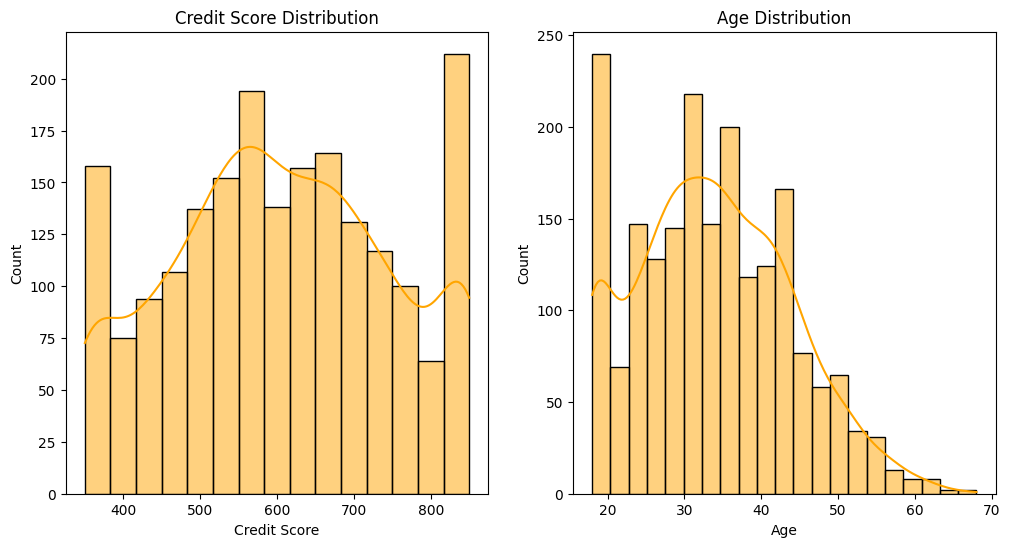

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df['credit_score'], kde=True, ax=ax[0], color = 'orange')
ax[0].set_title('Credit Score Distribution')
ax[0].set_xlabel('Credit Score')
sns.histplot(df['age'], kde=True, ax=ax[1], color = "orange")
ax[1].set_title('Age Distribution')
ax[1].set_xlabel('Age')
plt.show()

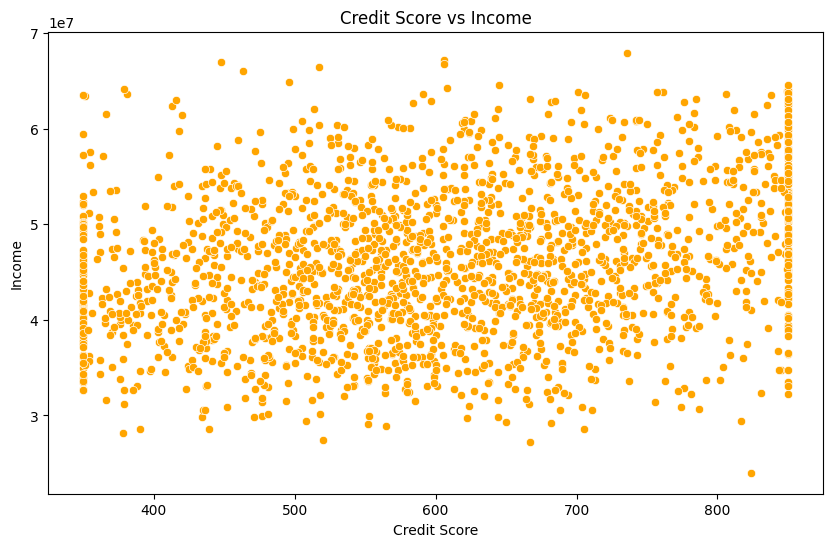

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='credit_score', y='income', data=df, color = "orange")
plt.title('Credit Score vs Income')
plt.xlabel('Credit Score')
plt.ylabel('Income')
plt.show()

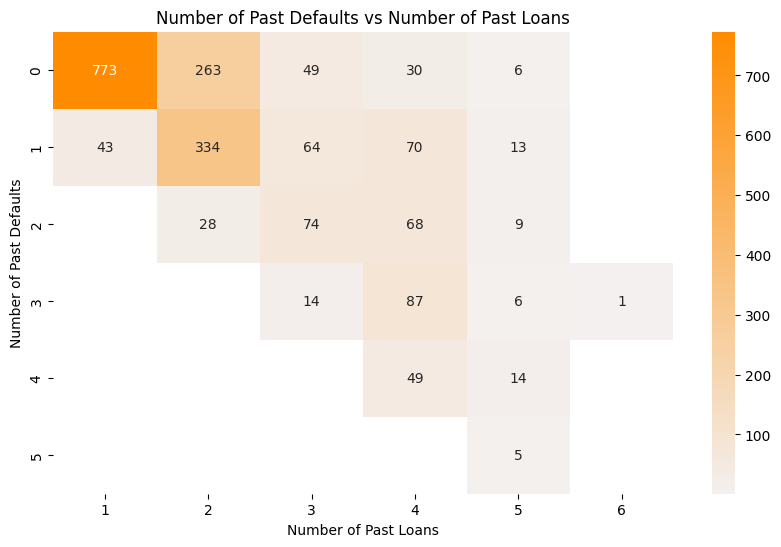

In [12]:
#heat map of number of past defaults and number of past loans flipped
plt.figure(figsize=(10, 6))
sns.heatmap(df.groupby(['number_past_default', 'number_past_loans']).size().unstack(), cmap=sns.light_palette("darkorange", as_cmap = True), annot=True, fmt='g')
plt.title('Number of Past Defaults vs Number of Past Loans')
plt.xlabel('Number of Past Loans')
plt.ylabel('Number of Past Defaults')
plt.show()

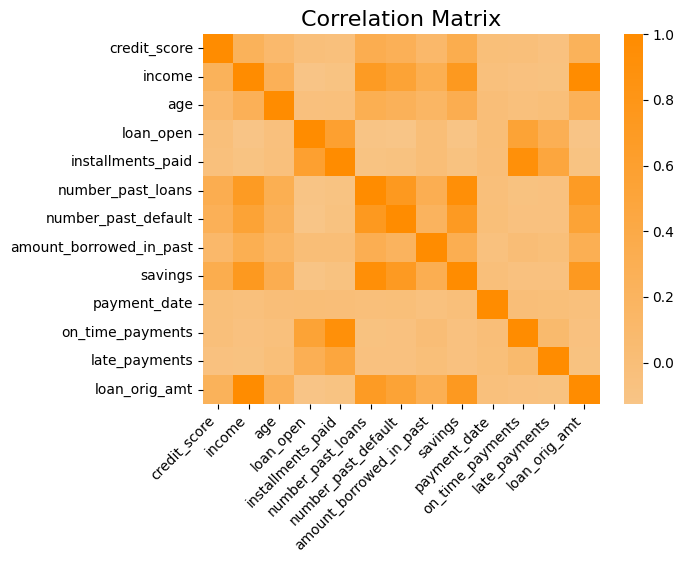

In [13]:
numerical = df.select_dtypes(include=[np.number]).drop(columns=['user_id', 'months_since_last_loan_opened'])
corr = numerical.corr()
ax = sns.heatmap(corr,  cmap=sns.light_palette("darkorange", as_cmap = True), center=0)
ax.set_title('Correlation Matrix', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Data Cleaning

### Irrelevant Columns and Observations

In [14]:
data = df.copy()

In [15]:
data = data.drop(columns=['payment_date'])

### Missing Values

In [16]:
print(data.shape)
data = data.dropna()
print(data.shape)

(2000, 17)
(2000, 17)


### Outliers



In [17]:
numeric_vars = data.select_dtypes(include=[np.number]).columns
for var in numeric_vars:
    mean = data[var].mean()
    sd = data[var].std()
    data['outliers'] = (data[var] - mean).abs() > 3*sd
    print("The variable", var, "has" ,data['outliers'].sum(), "outlier(s).")

The variable user_id has 0 outlier(s).
The variable credit_score has 0 outlier(s).
The variable income has 0 outlier(s).
The variable age has 2 outlier(s).
The variable loan_open has 0 outlier(s).
The variable installments_paid has 0 outlier(s).
The variable number_past_loans has 1 outlier(s).
The variable number_past_default has 68 outlier(s).
The variable amount_borrowed_in_past has 4 outlier(s).
The variable savings has 0 outlier(s).
The variable months_since_last_loan_opened has 0 outlier(s).
The variable on_time_payments has 0 outlier(s).
The variable late_payments has 49 outlier(s).
The variable loan_orig_amt has 0 outlier(s).


In [18]:
print("Data has", data.shape[0], "observations to begin.")
data['outliers'] = False
for var in numeric_vars:
    mean = data[var].mean()
    sd = data[var].std()
    data['outliers'] = data['outliers'] | ((data[var] - mean).abs() > 3*sd)
data = data[data['outliers'] == False].drop(columns=['outliers'])
print("Data now has", data.shape[0], "observations after dropping the outliers.")

Data has 2000 observations to begin.
Data now has 1877 observations after dropping the outliers.


### Duplicates

In [19]:
duplicates = data[data.duplicated(keep=False)]
print(duplicates.shape[0], "duplicates found.")
duplicates

0 duplicates found.


,user_id,gender,location,credit_score,income,age,loan_open,installments_paid,number_past_loans,number_past_default,amount_borrowed_in_past,savings,months_since_last_loan_opened,on_time_payments,late_payments,account_delq,loan_orig_amt


In [20]:
print(data.shape)
data = data.drop_duplicates(subset=data.columns.difference(['user_id'])).reset_index(drop=True)
print(data.shape)

(1877, 17)
(1877, 17)


## Feature Engineering

In [21]:
data.dtypes

user_id                            int64
gender                            object
location                          object
credit_score                       int64
income                           float64
age                                int64
loan_open                          int64
installments_paid                  int64
number_past_loans                  int64
number_past_default                int64
amount_borrowed_in_past          float64
savings                          float64
months_since_last_loan_opened      int64
on_time_payments                   int64
late_payments                      int64
account_delq                        bool
loan_orig_amt                    float64
dtype: object

### One Hot Encoding Categorial Features

In [22]:
obj_cols = data.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, drop='first')
one_hot_encoded = encoder.fit_transform(data[obj_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(obj_cols))

# Concatenate the one-hot encoded dataframe with the dataframe
df_encoded = pd.concat([data, one_hot_df], axis=1)
print(df_encoded.shape)

# Drop the original categorical columns
df_encoded = df_encoded.drop(obj_cols, axis=1)

# Display the resulting dataframe
df_encoded.head()

(1877, 20)


,user_id,credit_score,income,age,loan_open,installments_paid,number_past_loans,number_past_default,amount_borrowed_in_past,savings,months_since_last_loan_opened,on_time_payments,late_payments,account_delq,loan_orig_amt,gender_male,location_Cartagena,location_Medellin
0,2,683,59061386.68,36,1,2,3,1,2668376.98,10443480.10,0,2,0,False,1228536.30,1.00,0.00,0.00
1,3,707,49120858.72,18,1,2,2,1,1925105.41,4995385.66,0,2,0,False,1011201.17,0.00,0.00,1.00
2,4,734,54160279.87,21,1,1,2,1,2882690.74,4219940.49,0,1,0,False,1122043.41,1.00,0.00,1.00
3,5,733,41387442.56,59,1,1,1,0,1659044.74,1515155.70,0,1,0,False,856923.84,1.00,1.00,0.00
4,6,350,44683746.40,24,1,1,1,0,954182.41,2455148.57,0,0,1,False,915073.83,0.00,1.00,0.00


### Prepare Outcome

In [23]:
churn_df['churn'] = churn_df['months_since_last_loan_opened_current'].apply(lambda x: 1 if x > 5 else 0)
churn_df.head(10)

,user_id,months_since_last_loan_opened_current,churn
0,1,9,1
1,2,4,0
2,3,3,0
3,4,4,0
4,5,2,0
5,6,3,0
6,7,3,0
7,8,2,0
8,9,0,0
9,10,0,0


In [24]:
data_for_log_reg = df_encoded.merge(churn_df, on='user_id', how='left')
data_for_log_reg = data_for_log_reg.drop(columns=['months_since_last_loan_opened_current', 'user_id'])
data_for_log_reg = data_for_log_reg[['churn'] + [col for col in data_for_log_reg.columns if col != 'churn']]
data_for_log_reg.head()

,churn,credit_score,income,age,loan_open,installments_paid,number_past_loans,number_past_default,amount_borrowed_in_past,savings,months_since_last_loan_opened,on_time_payments,late_payments,account_delq,loan_orig_amt,gender_male,location_Cartagena,location_Medellin
0,0,683,59061386.68,36,1,2,3,1,2668376.98,10443480.10,0,2,0,False,1228536.30,1.00,0.00,0.00
1,0,707,49120858.72,18,1,2,2,1,1925105.41,4995385.66,0,2,0,False,1011201.17,0.00,0.00,1.00
2,0,734,54160279.87,21,1,1,2,1,2882690.74,4219940.49,0,1,0,False,1122043.41,1.00,0.00,1.00
3,0,733,41387442.56,59,1,1,1,0,1659044.74,1515155.70,0,1,0,False,856923.84,1.00,1.00,0.00
4,0,350,44683746.40,24,1,1,1,0,954182.41,2455148.57,0,0,1,False,915073.83,0.00,1.00,0.00


### Split data into predictive features and outcome feature

In [25]:
X = data_for_log_reg.drop(columns=['churn'])
y = data_for_log_reg['churn']

## Logistic Regression

### Basic Example

In [26]:
clf = LogisticRegression(random_state=1).fit(X, y)
y_predict=clf.predict(X)
data_with_predictions = data_for_log_reg.copy()
data_with_predictions['predicted_churn'] = y_predict
data_with_predictions = data_with_predictions[['churn', 'predicted_churn'] + [col for col in data_with_predictions.columns if col not in ['churn', 'predicted_churn']]]
data_with_predictions.head(n=10)

,churn,predicted_churn,credit_score,income,age,loan_open,installments_paid,number_past_loans,number_past_default,amount_borrowed_in_past,savings,months_since_last_loan_opened,on_time_payments,late_payments,account_delq,loan_orig_amt,gender_male,location_Cartagena,location_Medellin
0,0,0,683,59061386.68,36,1,2,3,1,2668376.98,10443480.10,0,2,0,False,1228536.30,1.00,0.00,0.00
1,0,0,707,49120858.72,18,1,2,2,1,1925105.41,4995385.66,0,2,0,False,1011201.17,0.00,0.00,1.00
2,0,0,734,54160279.87,21,1,1,2,1,2882690.74,4219940.49,0,1,0,False,1122043.41,1.00,0.00,1.00
3,0,0,733,41387442.56,59,1,1,1,0,1659044.74,1515155.70,0,1,0,False,856923.84,1.00,1.00,0.00
4,0,0,350,44683746.40,24,1,1,1,0,954182.41,2455148.57,0,0,1,False,915073.83,0.00,1.00,0.00
5,0,0,394,47267811.80,30,1,1,3,0,2907275.29,5052268.01,0,0,1,False,990287.24,1.00,0.00,1.00
6,0,0,361,49821045.19,33,0,0,2,0,3041399.11,5527570.33,0,0,0,False,1035419.27,1.00,0.00,1.00
7,0,0,764,37992844.21,27,1,2,1,0,2318509.76,1493055.96,0,2,0,False,786430.92,1.00,1.00,0.00
8,0,0,413,36086220.62,32,1,1,1,0,2624005.19,2223195.56,0,1,0,False,742558.45,1.00,1.00,0.00
9,0,0,539,50072324.38,34,1,1,3,2,2533476.67,5004669.89,0,1,0,False,1027130.22,1.00,0.00,1.00


In [27]:
print('The model correctly classified,', round(clf.score(X,y)*100,2), 'percent of observations.')

The model correctly classified, 83.7 percent of observations.


In [28]:
#gen colum where 1 is a correct prediction and 0 is an incorrect prediction
data_with_predictions['correct'] = data_with_predictions['churn'] == data_with_predictions['predicted_churn']
#sum the correct column to get the number of correct predictions
num_correct = data_with_predictions['correct'].sum()
num_correct/len(data_with_predictions)

0.83697389451252

### Supervised Learning Example

#### Training and Test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
print('Original data shape is', data_for_log_reg.shape, 'X training shape is', X_train.shape, 'y training shape is', y_train.shape, 'X test shape is', X_test.shape, 'y test shape is', y_test.shape)

Original data shape is (1877, 18) X training shape is (1501, 17) y training shape is (1501,) X test shape is (376, 17) y test shape is (376,)


In [30]:
clf_train = LogisticRegression(random_state=0).fit(X_train, y_train)
print('The model correctly classified,', round(clf_train.score(X_test,y_test)*100,2), 'percent of observations.')

The model correctly classified, 82.71 percent of observations.


#### Cross Validation

In [31]:
clf_cv = LogisticRegressionCV(cv=5, random_state=0, max_iter=2000).fit(X, y)
print(clf_cv.scores_[1])
scores = cross_val_score(clf_cv, X, y, cv=5)
print('The model correctly classified,', round(scores.mean()*100,2), 'percent of observations.')

[[0.83510638 0.83510638 0.83510638 0.83510638 0.83510638 0.83510638
  0.83510638 0.83510638 0.83510638 0.83510638]
 [0.84574468 0.84574468 0.84574468 0.84574468 0.84574468 0.84574468
  0.84574468 0.84574468 0.84574468 0.84574468]
 [0.83733333 0.83733333 0.83733333 0.83733333 0.83733333 0.83733333
  0.83733333 0.83733333 0.83733333 0.83733333]
 [0.832      0.832      0.832      0.832      0.832      0.832
  0.832      0.832      0.832      0.832     ]
 [0.82933333 0.82933333 0.82933333 0.82933333 0.82933333 0.82933333
  0.82933333 0.82933333 0.82933333 0.82933333]]
The model correctly classified, 83.64 percent of observations.


## Decision Tree

In [32]:
#build a decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.metrics import accuracy_score

clf_tree = DecisionTreeClassifier(random_state=0)
clf_tree = clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
print('The model correctly classified,', round(accuracy_score(y_test, y_pred)*100,2), 'percent of observations.')


The model correctly classified, 88.03 percent of observations.


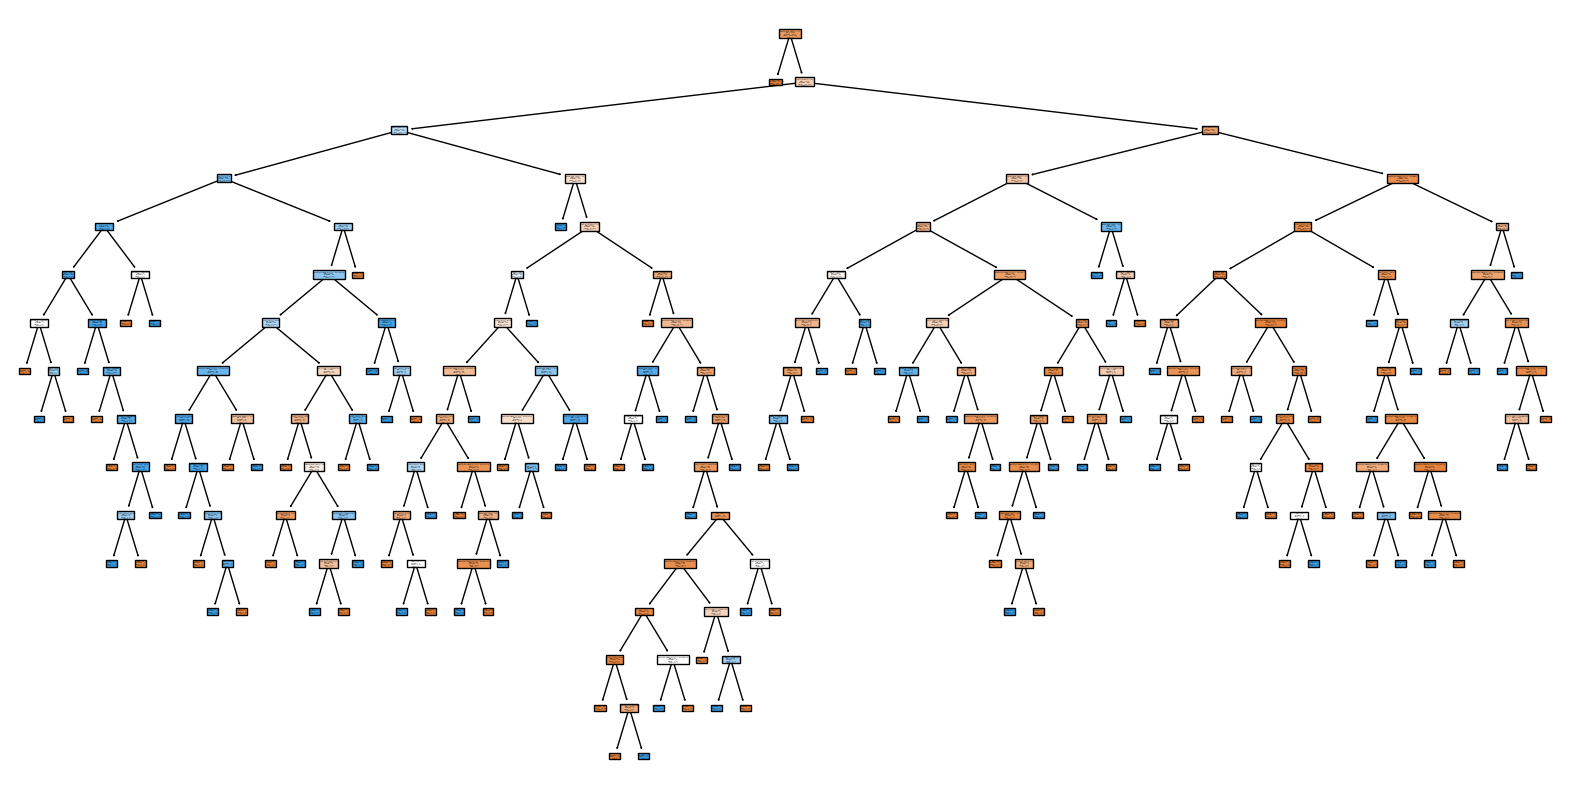

In [33]:
#plot the tree
plt.figure(figsize=(20,10))
plot_tree(clf_tree, filled=True, feature_names=X.columns, class_names=['0', '1'])
plt.show()

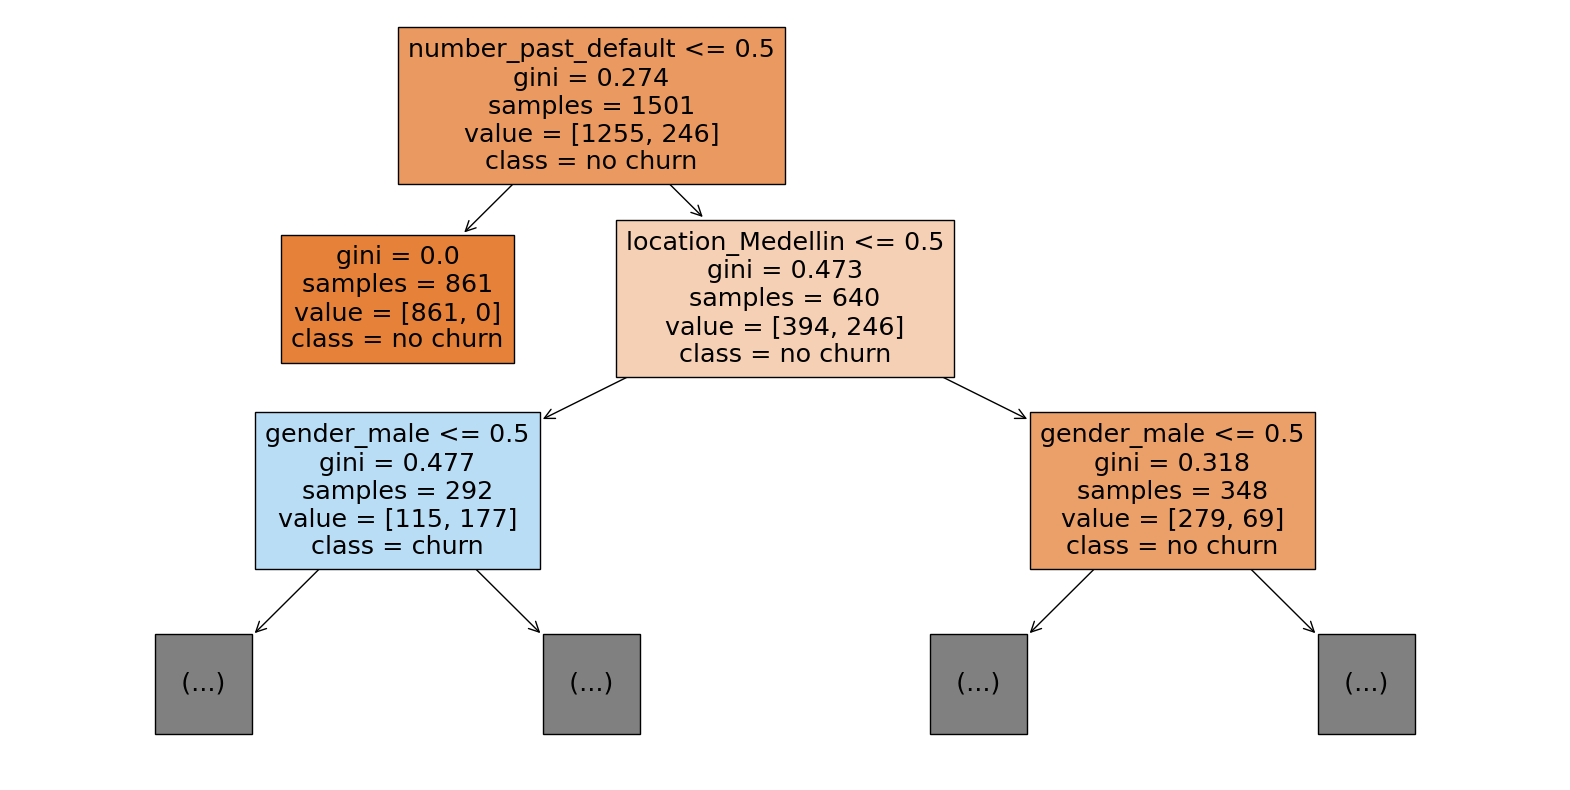

In [34]:
#zoom in on one branch of the tree
plt.figure(figsize=(20,10))
plot_tree(clf_tree, filled=True, feature_names=X.columns, class_names=['no churn', 'churn'], max_depth=2)
plt.show()

In [35]:
#cross validate a decision tree
scores = cross_val_score(clf_tree, X, y, cv=5)
print(scores)
print('The model correctly classified,', round(scores.mean()*100,2), 'percent of observations.')

[0.8856383  0.89361702 0.888      0.90933333 0.888     ]
The model correctly classified, 89.29 percent of observations.
